In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import sys

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt
import cv2

import os

'''import tqdm
import pdb
'''

'import tqdm\nimport pdb\n'

In [ ]:
'''# Import the necessary library
from google.colab import drive, files
# Mount Google Drive
drive.mount('/content/drive')'''

"# Import the necessary library\nfrom google.colab import drive, files\n# Mount Google Drive\ndrive.mount('/content/drive')"

### Functions

In [ ]:
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [ ]:
class ComplexGaborLayer2D(nn.Module):
    '''
        Implicit representation with complex Gabor nonlinearity with 2D activation function

        Inputs;
            in_features: Input features
            out_features; Output features
            bias: if True, enable bias for the linear operation
            is_first: Legacy SIREN parameter
            omega_0: Legacy SIREN parameter
            omega0: Frequency of Gabor sinusoid term
            sigma0: Scaling of Gabor Gaussian term
            trainable: If True, omega and sigma are trainable parameters
    '''

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega0=10.0, sigma0=10.0,
                 trainable=False):
        super().__init__()
        self.omega_0 = omega0
        self.scale_0 = sigma0
        self.is_first = is_first

        self.in_features = in_features

        if self.is_first:
            dtype = torch.float
        else:
            dtype = torch.cfloat

        #trainable=True ###########################

        # Set trainable parameters if they are to be simultaneously optimized
        self.omega_0 = nn.Parameter(self.omega_0*torch.ones(1), trainable)
        self.scale_0 = nn.Parameter(self.scale_0*torch.ones(1), trainable)

        self.linear = nn.Linear(in_features,
                                out_features,
                                bias=bias,
                                dtype=dtype)

        # Second Gaussian window
        self.scale_orth = nn.Linear(in_features,
                                    out_features,
                                    bias=bias,
                                    dtype=dtype)

    def forward(self, input):
        lin = self.linear(input)

        scale_x = lin
        scale_y = self.scale_orth(input)
        #print('Input\n',input,'\nX\n',scale_x,'\nY\n',scale_y,'\nlin\n',lin)
        freq_term = 1j*self.omega_0*lin #torch.exp(1j*self.omega_0*lin)
        #freq_term = torch.cos( self.omega_0*lin)#########################
        #freq_term = torch.complex(torch.cos( self.omega_0*lin),torch.sin( self.omega_0*lin))
        arg = scale_x.abs().square() + scale_y.abs().square()
        gauss_term = -self.scale_0*self.scale_0*arg#torch.exp(-self.scale_0*self.scale_0*arg)

        return torch.exp(freq_term+gauss_term)#freq_term*gauss_term


In [ ]:
class WIRE(nn.Module):
    def __init__(self, in_features, hidden_features,
                 hidden_layers,
                 out_features, outermost_linear=True,
                 first_omega_0=10, hidden_omega_0=10., scale=10.0,
                 pos_encode=False, sidelength=512, fn_samples=None,
                 use_nyquist=True):
        super().__init__()

        # All results in the paper were with the default complex 'gabor' nonlinearity
        self.nonlin = ComplexGaborLayer2D

        # Since complex numbers are two real numbers, reduce the number of
        # hidden parameters by 4
        hidden_features = int(hidden_features/2)
        dtype = torch.cfloat
        #self.complex = True

        #dtype = torch.float #####################################
        #self.complex = False #######################################

        self.wavelet = 'gabor'

        # Legacy parameter
        self.pos_encode = False

        self.net = []
        self.net.append(self.nonlin(in_features,
                                    hidden_features,
                                    omega0=first_omega_0,
                                    sigma0=scale,
                                    is_first=True,
                                    trainable=False))

        for i in range(hidden_layers):
            self.net.append(self.nonlin(hidden_features,
                                        hidden_features,
                                        omega0=hidden_omega_0,
                                        sigma0=scale))

        final_linear = nn.Linear(hidden_features,
                                 out_features,
                                 dtype=dtype)
        self.net.append(final_linear)

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        #print(output.shape)
        #print(output.real)

        if self.wavelet == 'gabor':
            return output.real,coords

        return output,coords

In [ ]:
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

'''    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate'''




'    def forward_with_intermediate(self, input):\n        # For visualization of activation distributions\n        intermediate = self.omega_0 * self.linear(input)\n        return torch.sin(intermediate), intermediate'

In [ ]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        #print(output.shape)
        return output, coords

In [ ]:
class WIRE_SIREN(nn.Module):
    def __init__(self, in_features, hidden_features,
                 hidden_layers,
                 out_features, outermost_linear=True,
                 first_omega_0=10, hidden_omega_0=10., scale=10.0,
                 pos_encode=False, sidelength=512, fn_samples=None,
                 use_nyquist=True):
        super().__init__()

        # All results in the paper were with the default complex 'gabor' nonlinearity
        self.nonlin = ComplexGaborLayer2D

        # Since complex numbers are two real numbers, reduce the number of
        # hidden parameters by 4
        hidden_features = int(hidden_features)
        dtype = torch.cfloat
        self.complex = True

        #dtype = torch.float #####################################
        #self.complex = False #######################################

        self.wavelet = 'gabor'

        # Legacy parameter
        self.pos_encode = False

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=30))


        for i in range(hidden_layers):
            self.net.append(self.nonlin(hidden_features,
                                    hidden_features,
                                    omega0=5,
                                    sigma0=5,
                                    is_first=True,
                                    trainable=False))

        final_linear = nn.Linear(hidden_features,
                                 out_features,
                                 dtype=dtype)
        self.net.append(final_linear)

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        #print(output.shape)
        #print(output.real)

        if self.wavelet == 'gabor':
            return output.real,coords

        return output,coords

In [ ]:
class RaisedCosineLayer(nn.Module):
    '''
        Implicit representation with Raised Cosine activation.

        Inputs;
            in_features: Input features
            out_features; Output features
            bias: if True, enable bias for the linear operation
            is_first: Legacy SIREN parameter
            omega_0: Legacy SIREN parameter
            omega0: Frequency of Gabor sinusoid term
            sigma0: Scaling of Gabor Gaussian term
            trainable: If True, omega and sigma are trainable parameters
    '''

    def __init__(self,
                 in_features,
                 out_features,
                 bias=True,
                 is_first=False,
                 beta0=0.5,
                 T0=0.1,
                 trainable=False):
        super().__init__()
        self.beta0 = beta0
        self.T0 = T0
        self.is_first = is_first

        self.in_features = in_features
        self.out_features = out_features

        if self.is_first:
            dtype = torch.float  # 32 bit
        else:
            dtype = torch.float  # complex 64 bit

        # Set trainable parameters if they are to be simultaneously optimized
        self.T0 = nn.Parameter(self.T0 * torch.ones(1), trainable)
        self.beta0 = nn.Parameter(self.beta0 * torch.ones(1), trainable)

        self.linear = nn.Linear(in_features,
                                out_features,
                                bias=bias,
                                dtype=dtype)

        # # Second Gaussian window
        # self.scale_orth = nn.Linear(in_features,
        #                             out_features,
        #                             bias=bias,
        #                             dtype=dtype)

    def forward(self, input):
        lin = self.linear(input)
        # beta = self.beta0 * lin
        # T = self.T0 * lin
        device = "cuda:0"
        #print(input.device , self.beta0.device,self.T0.device)
        #A = torch.ones(input.shape[0] , device = device )*(1-self.beta0)/2*self.T0
        #B = torch.ones(input.shape[0] , device = device)*(1+self.beta0)/2*self.T0
        #ABS = lin.abs()
        #print(A.dtype , B.dtype , ABS.dtype, self.T0.dtype , self.beta0.dtype )
        #return torch.heaviside(A - ABS, torch.tensor([0.0] , device = device)) + 0.5 * (1 + torch.cos(torch.pi * self.T0 * (ABS - (1 - self.beta0 / 2 * self.T0)) / self.beta0) * (torch.heaviside(B - ABS, torch.tensor([0.0], device = device)) - torch.heaviside(A - ABS, torch.tensor([0.0], device = device))))
        #return  0.5 * (1 + torch.cos(torch.pi * self.T0 * (ABS - (1 - self.beta0 / 2 * self.T0)) / self.beta0))

        A = torch.ones(input.shape[0], device=device) * (1 - self.beta0) / 2 * self.T0
        B = torch.ones(input.shape[0], device=device) * (1 + self.beta0) / 2 * self.T0
        ABS = input.abs()

        epsilon = 1e-5

        # Compute the modified expression
        heaviside_A = 0.5 * (1 + torch.tanh( (A - ABS) / epsilon))
        heaviside_B = 0.5 * (1 + torch.tanh( (B - ABS)/ epsilon))

        result = (
            heaviside_A +
            0.5 * (1 + torch.cos(torch.pi * self.T0 * (ABS - (1 - self.beta0 / 2 * self.T0)) / self.beta0) * (heaviside_B - heaviside_A))
        )
        print(result.shape)
        return result


In [ ]:
class INR_Raised_Cosine(nn.Module):
    def __init__(self, in_features,
                 hidden_features,
                 hidden_layers,
                 out_features,
                 outermost_linear=True,
                 first_beta=0.3,
                 hidden_beta=0.5,
                 T=0.1,
                 pos_encode=False,
                 sidelength=512,
                 fn_samples=None,
                 use_nyquist=True):
        super().__init__()

        # All results in the paper were with the default complex 'gabor' nonlinearity
        self.nonlin = RaisedCosineLayer

        # Since complex numbers are two real numbers, reduce the number of
        # hidden parameters by 2 (NOTE: Skipped this)
        # hidden_features = int(hidden_features / np.sqrt(2))
        dtype = torch.float
        # self.complex = True
        # self.wavelet = 'gabor'

        # Legacy parameter
        self.pos_encode = False

        self.net = []
        self.net.append(self.nonlin(in_features,
                                    hidden_features,
                                    beta0=first_beta,
                                    T0=T,
                                    is_first=True,
                                    trainable=False))

        for i in range(hidden_layers):
            self.net.append(self.nonlin(hidden_features,
                                        hidden_features,
                                        beta0=hidden_beta,
                                        is_first=True,
                                        T0=T))

        final_linear = nn.Linear(hidden_features,
                                 out_features,
                                 dtype=dtype)
        self.net.append(final_linear)

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        #print(output.shape)
        #print(output.real)
        return output,coords

In [ ]:
# function to get the fourier transform of an image
def get_fourier(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    return torch.tensor(fshift)

In [ ]:
# function to calculate the gradient - img is a numpy array

def compute_gradient(img , kernel_size = 3):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobelxy_mag = np.sqrt(sobelx**2 + sobely**2)
    grad_angle = np.arctan2(sobely, sobelx)
    return sobelxy_mag, grad_angle , sobelx, sobely # returns np arrrays

In [ ]:
# function to get the laplacian of an image (np array)
def compute_laplacian(img, kernel_size = 3):
    #laplacian = cv2.Laplacian(img, cv2.CV_64F, ksize=kernel_size)
    sobelx2 = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobelx2 = cv2.Sobel(sobelx2, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely2 = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobely2 =cv2.Sobel(sobely2, cv2.CV_64F, 1, 0, ksize=kernel_size)
    laplacian = sobelx2 + sobely2
    return laplacian # returns an np array

In [ ]:
import scipy.ndimage

def compute_gradient(image):
    # Compute gradients along x and y directions
    dx = scipy.ndimage.sobel(image, axis=0, mode='constant')
    dy = scipy.ndimage.sobel(image, axis=1, mode='constant')
    grad_mag = np.sqrt(np.power(dx,2)+np.power(dy,2))
    grad_angle = np.arctan2(dy, dx)
    return (grad_mag,grad_angle,dx, dy)

def compute_laplacian(image):
    # Compute the Laplacian using a convolution with a specific kernel
    laplacian_kernel = np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])
    laplacian = scipy.ndimage.convolve(image, laplacian_kernel, mode='constant')
    return laplacian

In [ ]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [ ]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [ ]:
def PSNR( img , original_img):
  MSE = ((img - original_img)**2).mean()
  PSNR_val = 10 * np.log10(img.max()/MSE)
  return PSNR_val

### Initiation

In [ ]:
# Reconstruction - Gabor
# lr = 1.5e-3
# w0 = 20 , w_hid = 20
# s0 =10

# Noise Filter - Gabor
# lr = 5e-3
# w0 = 5 , w_hid = 5
# s0 = 5

# Noise Filter - Siren
# lr = 1e-4
# w0 , w_hidden =


In [ ]:
img_size = 256
cman = get_cameraman_tensor(img_size)
cman.shape

torch.Size([1, 256, 256])

In [ ]:
cameraman = ImageFitting(img_size)
print(cameraman.pixels.shape)

dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

torch.Size([65536, 1])


In [ ]:
original_img = cameraman.pixels.view(img_size, img_size).cpu().numpy()
original_img = original_img.copy()

In [ ]:

noise_factor = 0.5
# add white noise to the image
noise = torch.randn_like(cameraman.pixels) * noise_factor
# add high frequency noise to the image

cameraman.pixels += noise

'''plt.figure( figsize=(10,10)  )
plt.title("Image with Gaussian Noise")
plt.subplot(2, 2, 1)
plt.imshow(cameraman.pixels.view(img_size, img_size).cpu().numpy())

plt.subplot(2, 2, 2)
noisy_mag = torch.abs(get_fourier(cameraman.pixels.view(img_size, img_size).cpu().numpy()))
plt.imshow(np.log(noisy_mag+1))
#plt.show()

plt.subplot(2, 2, 3)
plt.hist( cameraman.pixels.view(-1).cpu().numpy(), bins=img_size, density=True)

save_path = '/content/drive/My Drive/INR/Results/Original_Noise_Image'
plt.savefig(save_path,   pad_inches=0.1)
plt.show()'''

'plt.figure( figsize=(10,10)  )\nplt.title("Image with Gaussian Noise")\nplt.subplot(2, 2, 1)\nplt.imshow(cameraman.pixels.view(img_size, img_size).cpu().numpy())\n\nplt.subplot(2, 2, 2)\nnoisy_mag = torch.abs(get_fourier(cameraman.pixels.view(img_size, img_size).cpu().numpy()))\nplt.imshow(np.log(noisy_mag+1))\n#plt.show()\n\nplt.subplot(2, 2, 3)\nplt.hist( cameraman.pixels.view(-1).cpu().numpy(), bins=img_size, density=True)\n\nsave_path = \'/content/drive/My Drive/INR/Results/Original_Noise_Image\'\nplt.savefig(save_path,   pad_inches=0.1)\nplt.show()'

### Implimentation - WIRE

In [ ]:
psnr_steps = []

In [ ]:
img_INR = WIRE(in_features=2, out_features=1, hidden_features=img_size,
                  hidden_layers=2, outermost_linear=True , first_omega_0=5 , hidden_omega_0=5 , scale=5)
img_INR.cuda()

WIRE(
  (net): Sequential(
    (0): ComplexGaborLayer2D(
      (linear): Linear(in_features=2, out_features=128, bias=True)
      (scale_orth): Linear(in_features=2, out_features=128, bias=True)
    )
    (1): ComplexGaborLayer2D(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (scale_orth): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): ComplexGaborLayer2D(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (scale_orth): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=5e-3, params=img_INR.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

In [ ]:
for step in range(total_steps):

    model_output, coords = img_INR(model_input)
    loss = ((model_output - ground_truth)**2).mean()
    model_output_cpu = model_output.cpu().view(img_size,img_size).detach().numpy()
    PSNR_reconst = PSNR(model_output_cpu , original_img)
    psnr_steps.append(PSNR_reconst)
    model_output_cpu = cv2.convertScaleAbs(model_output_cpu , alpha = 0.5 )
    #print(model_output_cpu.shape)
    #print(min(model_output_cpu.flatten()),max(model_output_cpu.flatten()))
    if not step % steps_til_summary:
        print(step , loss)
        #plot_details(model_output_cpu,step,loss,noise_factor = noise_factor)
    optim.zero_grad()
    loss.backward()
    optim.step()

0 tensor(0.5893, device='cuda:0', grad_fn=<MeanBackward0>)
10 tensor(0.2850, device='cuda:0', grad_fn=<MeanBackward0>)
20 tensor(0.2716, device='cuda:0', grad_fn=<MeanBackward0>)
30 tensor(0.2666, device='cuda:0', grad_fn=<MeanBackward0>)
40 tensor(0.2634, device='cuda:0', grad_fn=<MeanBackward0>)
50 tensor(0.2608, device='cuda:0', grad_fn=<MeanBackward0>)
60 tensor(0.2602, device='cuda:0', grad_fn=<MeanBackward0>)
70 tensor(0.2566, device='cuda:0', grad_fn=<MeanBackward0>)
80 tensor(0.2546, device='cuda:0', grad_fn=<MeanBackward0>)
90 tensor(0.2529, device='cuda:0', grad_fn=<MeanBackward0>)
100 tensor(0.2512, device='cuda:0', grad_fn=<MeanBackward0>)
110 tensor(0.2497, device='cuda:0', grad_fn=<MeanBackward0>)
120 tensor(0.2487, device='cuda:0', grad_fn=<MeanBackward0>)
130 tensor(0.2471, device='cuda:0', grad_fn=<MeanBackward0>)
140 tensor(0.2453, device='cuda:0', grad_fn=<MeanBackward0>)
150 tensor(0.2439, device='cuda:0', grad_fn=<MeanBackward0>)
160 tensor(0.2430, device='cuda:0',

In [ ]:
noise_img_original = (cameraman.pixels.view(img_size,img_size).detach().numpy())
PSNR_noisy = PSNR(noise_img_original,original_img)

In [ ]:
PSNR_reconst

15.529589653015137

In [ ]:
print(model_output.shape,coords.shape)

torch.Size([1, 65536, 1]) torch.Size([1, 65536, 2])


In [ ]:
model_output[0]

tensor([[ 0.2710],
        [ 0.3055],
        [ 0.3401],
        ...,
        [-0.0740],
        [ 0.1523],
        [ 0.6565]], device='cuda:0', grad_fn=<SelectBackward0>)

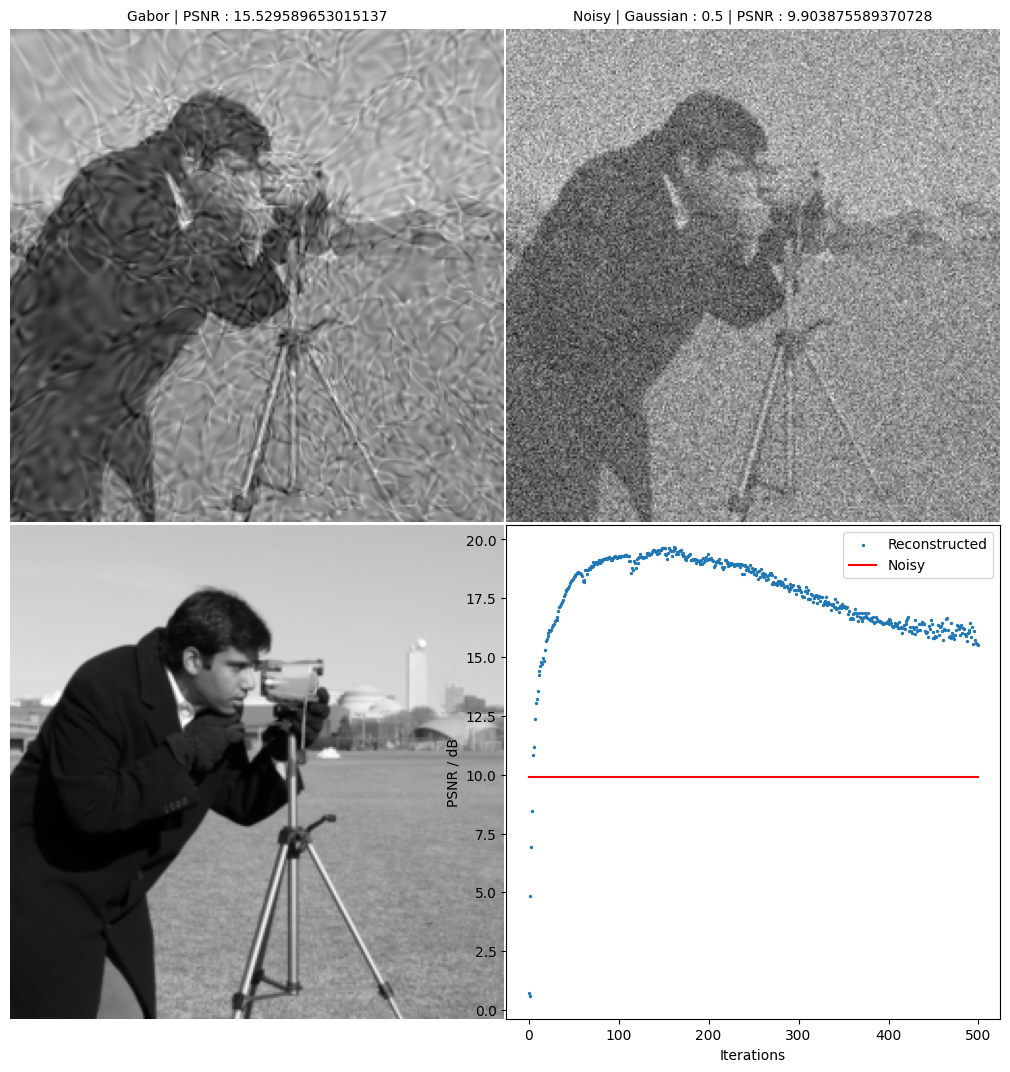

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.title(f"Gabor | PSNR : {PSNR_reconst}" , fontsize = 10)
plt.imshow(model_output.cpu().view(img_size,img_size).detach().numpy(),cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title(f"Noisy | Gaussian : {noise_factor} | PSNR : {PSNR_noisy}" , fontsize = 10)
plt.imshow(noise_img_original,cmap='gray')
plt.axis("off")

plt.subplot(2,2,3)
#plt.title("Original" , fontsize = 10)
plt.imshow(original_img,cmap='gray')
plt.axis("off")

plt.subplot(2,2,4)
#plt.figure(figsize=(10,5))
plt.scatter(range(len(psnr_steps)),psnr_steps , s = 2)
#plt.title(f"Gabor | Gaussian {noise_factor}")
plt.plot(np.ones(len(psnr_steps)) * PSNR_noisy , color = 'r')
plt.legend(["Reconstructed" , "Noisy"])
plt.xlabel('Iterations')
plt.ylabel("PSNR / dB")


plt.subplots_adjust(hspace=0.005, wspace=0.005, left=0.005, right=0.995, top=0.995, bottom=0.005)
plt.show()

In [ ]:
del img_INR

### Implimentation - SIREN

In [ ]:
psnr_steps = []

In [ ]:
img_INR = Siren( in_features=2, out_features=1, hidden_features=img_size,
                  hidden_layers=2, outermost_linear=True , first_omega_0=30 , hidden_omega_0=30)
img_INR.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_INR.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

In [ ]:
for step in range(total_steps):

    model_output, coords = img_INR(model_input)
    loss = ((model_output - ground_truth)**2).mean()
    model_output_cpu = model_output.cpu().view(img_size,img_size).detach().numpy()
    PSNR_reconst = PSNR(model_output_cpu , original_img)
    psnr_steps.append(PSNR_reconst)
    model_output_cpu = cv2.convertScaleAbs(model_output_cpu , alpha = 0.5 )
    #print(model_output_cpu.shape)
    #print(min(model_output_cpu.flatten()),max(model_output_cpu.flatten()))
    if not step % steps_til_summary:
        print(step , loss)
        #plot_details(model_output_cpu,step,loss,noise_factor = noise_factor)
    optim.zero_grad()
    loss.backward()
    optim.step()

0 tensor(0.5754, device='cuda:0', grad_fn=<MeanBackward0>)
10 tensor(0.3116, device='cuda:0', grad_fn=<MeanBackward0>)
20 tensor(0.2766, device='cuda:0', grad_fn=<MeanBackward0>)
30 tensor(0.2693, device='cuda:0', grad_fn=<MeanBackward0>)
40 tensor(0.2654, device='cuda:0', grad_fn=<MeanBackward0>)
50 tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward0>)
60 tensor(0.2611, device='cuda:0', grad_fn=<MeanBackward0>)
70 tensor(0.2596, device='cuda:0', grad_fn=<MeanBackward0>)
80 tensor(0.2583, device='cuda:0', grad_fn=<MeanBackward0>)
90 tensor(0.2570, device='cuda:0', grad_fn=<MeanBackward0>)
100 tensor(0.2558, device='cuda:0', grad_fn=<MeanBackward0>)
110 tensor(0.2546, device='cuda:0', grad_fn=<MeanBackward0>)
120 tensor(0.2534, device='cuda:0', grad_fn=<MeanBackward0>)
130 tensor(0.2522, device='cuda:0', grad_fn=<MeanBackward0>)
140 tensor(0.2510, device='cuda:0', grad_fn=<MeanBackward0>)
150 tensor(0.2498, device='cuda:0', grad_fn=<MeanBackward0>)
160 tensor(0.2485, device='cuda:0',

In [ ]:
noise_img_original = (cameraman.pixels.view(img_size,img_size).detach().numpy())
PSNR_noisy = PSNR(noise_img_original,original_img)

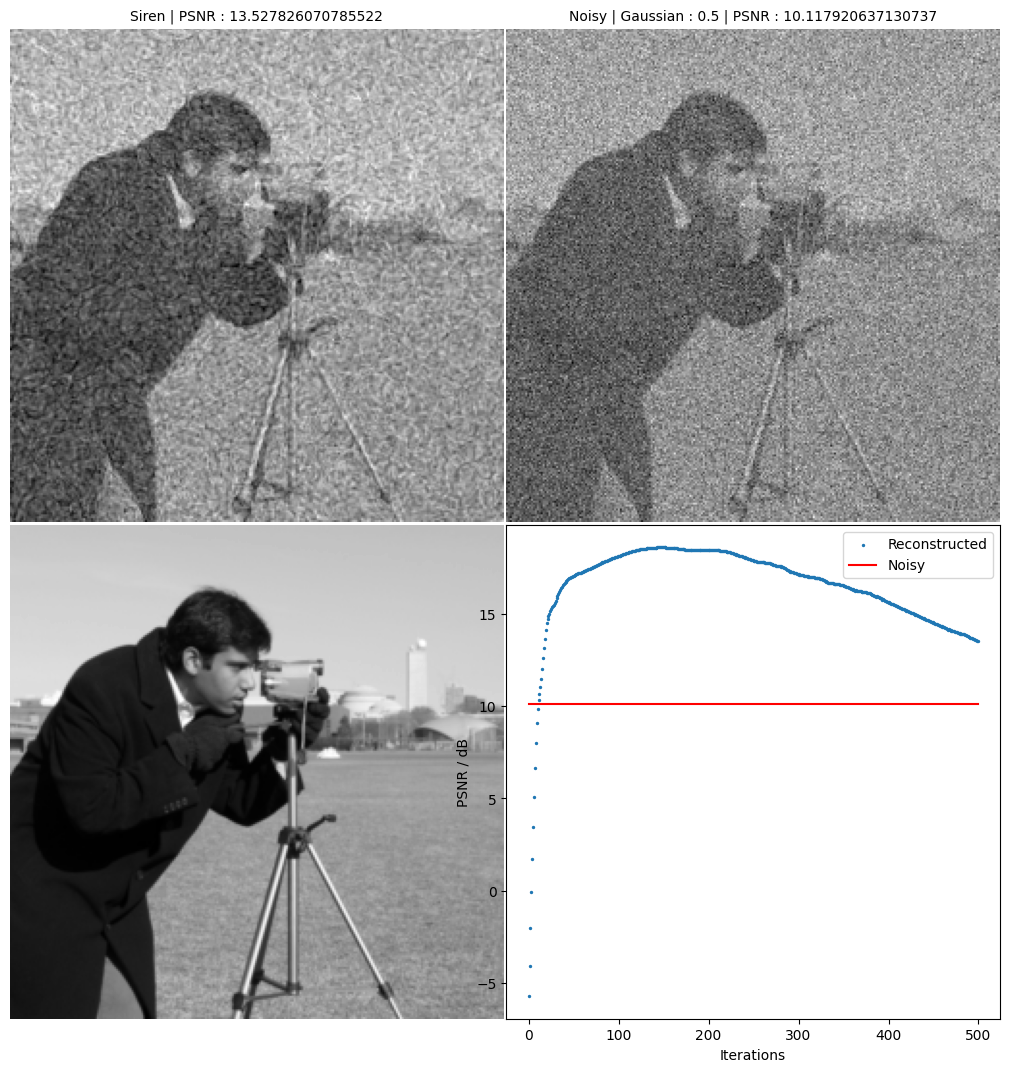

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.title(f"Siren | PSNR : {PSNR_reconst}" , fontsize = 10)
plt.imshow(model_output.cpu().view(img_size,img_size).detach().numpy(),cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title(f"Noisy | Gaussian : {noise_factor} | PSNR : {PSNR_noisy}" , fontsize = 10)
plt.imshow(noise_img_original,cmap='gray')
plt.axis("off")

plt.subplot(2,2,3)
#plt.title("Original" , fontsize = 10)
plt.imshow(original_img,cmap='gray')
plt.axis("off")

plt.subplot(2,2,4)
#plt.figure(figsize=(10,5))
plt.scatter(range(len(psnr_steps)),psnr_steps , s = 2)
#plt.title(f"Gabor | Gaussian {noise_factor}")
plt.plot(np.ones(len(psnr_steps)) * PSNR_noisy , color = 'r')
plt.legend(["Reconstructed" , "Noisy"])
plt.xlabel('Iterations')
plt.ylabel("PSNR / dB")


plt.subplots_adjust(hspace=0.005, wspace=0.005, left=0.005, right=0.995, top=0.995, bottom=0.005)
plt.show()

In [ ]:
del img_INR

### Implimentation - SIREN and WIRE

In [ ]:
psnr_steps = []

In [ ]:
img_INR = WIRE_SIREN(in_features=2, out_features=1, hidden_features=img_size,
                  hidden_layers=1, outermost_linear=True , first_omega_0=5 , hidden_omega_0=5 , scale=5)
img_INR.cuda()

WIRE_SIREN(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): ComplexGaborLayer2D(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (scale_orth): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_INR.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

In [ ]:
for step in range(total_steps):

    model_output, coords = img_INR(model_input)
    loss = ((model_output - ground_truth)**2).mean()
    model_output_cpu = model_output.cpu().view(img_size,img_size).detach().numpy()
    PSNR_reconst = PSNR(model_output_cpu , original_img)
    psnr_steps.append(PSNR_reconst)
    model_output_cpu = cv2.convertScaleAbs(model_output_cpu , alpha = 0.5 )
    #print(model_output_cpu.shape)
    #print(min(model_output_cpu.flatten()),max(model_output_cpu.flatten()))
    if not step % steps_til_summary:
        print(step , loss)
        #plot_details(model_output_cpu,step,loss,noise_factor = noise_factor)
    optim.zero_grad()
    loss.backward()
    optim.step()

0 tensor(0.5998, device='cuda:0', grad_fn=<MeanBackward0>)
10 tensor(0.4632, device='cuda:0', grad_fn=<MeanBackward0>)
20 tensor(0.3742, device='cuda:0', grad_fn=<MeanBackward0>)
30 tensor(0.3191, device='cuda:0', grad_fn=<MeanBackward0>)
40 tensor(0.2875, device='cuda:0', grad_fn=<MeanBackward0>)
50 tensor(0.2711, device='cuda:0', grad_fn=<MeanBackward0>)
60 tensor(0.2630, device='cuda:0', grad_fn=<MeanBackward0>)
70 tensor(0.2585, device='cuda:0', grad_fn=<MeanBackward0>)
80 tensor(0.2555, device='cuda:0', grad_fn=<MeanBackward0>)
90 tensor(0.2533, device='cuda:0', grad_fn=<MeanBackward0>)
100 tensor(0.2515, device='cuda:0', grad_fn=<MeanBackward0>)
110 tensor(0.2501, device='cuda:0', grad_fn=<MeanBackward0>)
120 tensor(0.2489, device='cuda:0', grad_fn=<MeanBackward0>)
130 tensor(0.2478, device='cuda:0', grad_fn=<MeanBackward0>)
140 tensor(0.2468, device='cuda:0', grad_fn=<MeanBackward0>)
150 tensor(0.2459, device='cuda:0', grad_fn=<MeanBackward0>)
160 tensor(0.2451, device='cuda:0',

In [ ]:
noise_img_original = (cameraman.pixels.view(img_size,img_size).detach().numpy())
PSNR_noisy = PSNR(noise_img_original,original_img)

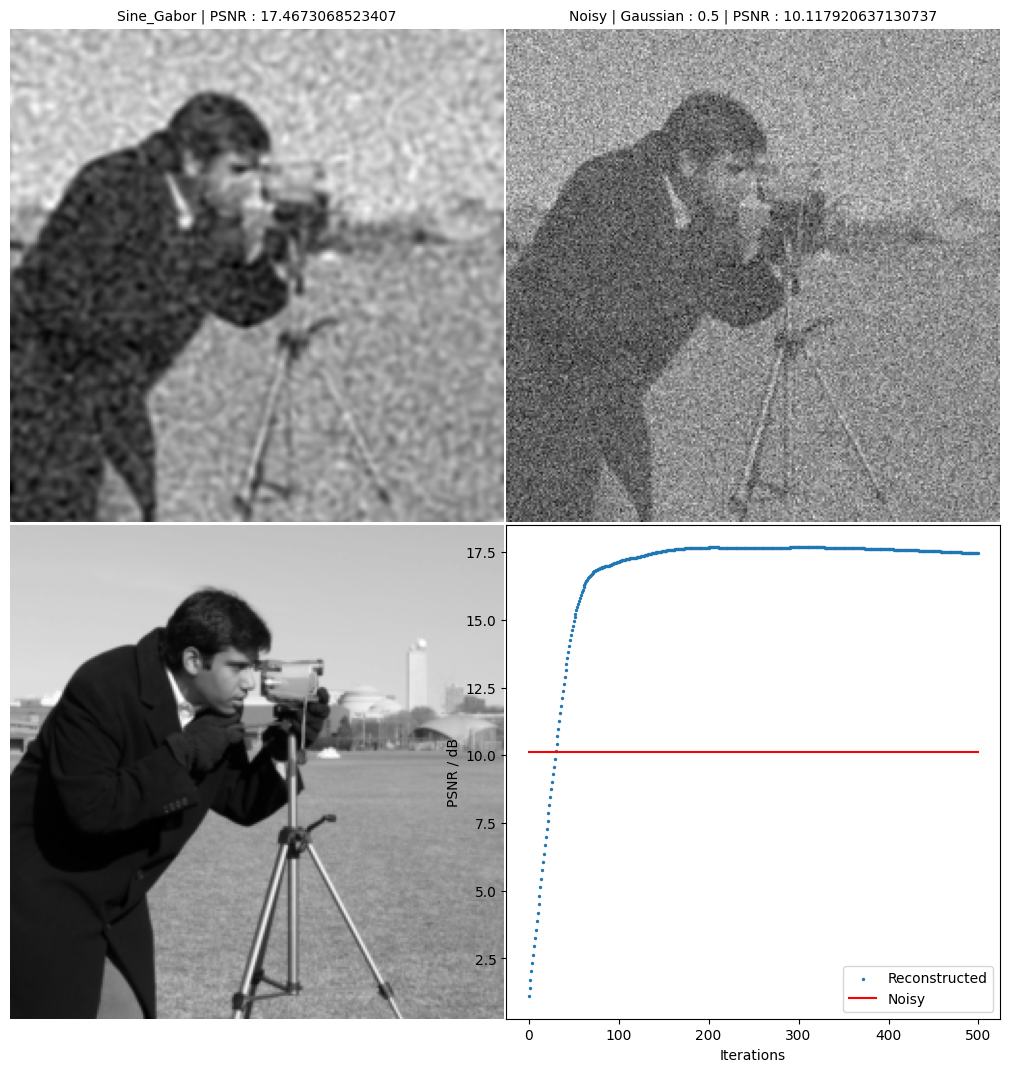

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.title(f"Sine_Gabor | PSNR : {PSNR_reconst}" , fontsize = 10)
plt.imshow(model_output.cpu().view(img_size,img_size).detach().numpy(),cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title(f"Noisy | Gaussian : {noise_factor} | PSNR : {PSNR_noisy}" , fontsize = 10)
plt.imshow(noise_img_original,cmap='gray')
plt.axis("off")

plt.subplot(2,2,3)
#plt.title("Original" , fontsize = 10)
plt.imshow(original_img,cmap='gray')
plt.axis("off")

plt.subplot(2,2,4)
#plt.figure(figsize=(10,5))
plt.scatter(range(len(psnr_steps)),psnr_steps , s = 2)
#plt.title(f"Gabor | Gaussian {noise_factor}")
plt.plot(np.ones(len(psnr_steps)) * PSNR_noisy , color = 'r')
plt.legend(["Reconstructed" , "Noisy"])
plt.xlabel('Iterations')
plt.ylabel("PSNR / dB")


plt.subplots_adjust(hspace=0.005, wspace=0.005, left=0.005, right=0.995, top=0.995, bottom=0.005)
plt.show()

In [ ]:
del img_INR

### Implimentation - Raised_Cosine

In [ ]:
psnr_steps = []

In [ ]:
'''class INR_Raised_Cosine(nn.Module):
    def __init__(self, in_features,
                 hidden_features,
                 hidden_layers,
                 out_features,
                 outermost_linear=True,
                 first_beta=0.3,
                 hidden_beta=0.5,
                 T=0.1,
                 pos_encode=False,
                 sidelength=512,
                 fn_samples=None,
                 use_nyquist=True):'''

'class INR_Raised_Cosine(nn.Module):\n    def __init__(self, in_features,\n                 hidden_features,\n                 hidden_layers,\n                 out_features,\n                 outermost_linear=True,\n                 first_beta=0.3,\n                 hidden_beta=0.5,\n                 T=0.1,\n                 pos_encode=False,\n                 sidelength=512,\n                 fn_samples=None,\n                 use_nyquist=True):'

In [ ]:
img_INR = INR_Raised_Cosine(in_features=2, out_features=1, hidden_features=img_size,
                  hidden_layers=2, outermost_linear=True , first_beta=0.3,  hidden_beta=0.5, T=0.1,)
img_INR.cuda()

INR_Raised_Cosine(
  (net): Sequential(
    (0): RaisedCosineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): RaisedCosineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): RaisedCosineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_INR.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

In [ ]:
for step in range(total_steps):

    model_output, coords = img_INR(model_input)
    loss = ((model_output - ground_truth)**2).mean()
    model_output_cpu = model_output.cpu().view(img_size,img_size).detach().numpy()
    PSNR_reconst = PSNR(model_output_cpu , original_img)
    psnr_steps.append(PSNR_reconst)
    model_output_cpu = cv2.convertScaleAbs(model_output_cpu , alpha = 0.5 )
    #print(model_output_cpu.shape)
    #print(min(model_output_cpu.flatten()),max(model_output_cpu.flatten()))
    if not step % steps_til_summary:
        print(step , loss)
        #plot_details(model_output_cpu,step,loss,noise_factor = noise_factor)
    optim.zero_grad()
    loss.backward()
    optim.step()

torch.Size([1, 65536, 2])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (65536x2 and 256x256)

In [ ]:
noise_img_original = (cameraman.pixels.view(img_size,img_size).detach().numpy())
PSNR_noisy = PSNR(noise_img_original,original_img)

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.title(f"Sine_Gabor | PSNR : {PSNR_reconst}" , fontsize = 10)
plt.imshow(model_output.cpu().view(img_size,img_size).detach().numpy(),cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title(f"Noisy | Gaussian : {noise_factor} | PSNR : {PSNR_noisy}" , fontsize = 10)
plt.imshow(noise_img_original,cmap='gray')
plt.axis("off")

plt.subplot(2,2,3)
#plt.title("Original" , fontsize = 10)
plt.imshow(original_img,cmap='gray')
plt.axis("off")

plt.subplot(2,2,4)
#plt.figure(figsize=(10,5))
plt.scatter(range(len(psnr_steps)),psnr_steps , s = 2)
#plt.title(f"Gabor | Gaussian {noise_factor}")
plt.plot(np.ones(len(psnr_steps)) * PSNR_noisy , color = 'r')
plt.legend(["Reconstructed" , "Noisy"])
plt.xlabel('Iterations')
plt.ylabel("PSNR / dB")


plt.subplots_adjust(hspace=0.005, wspace=0.005, left=0.005, right=0.995, top=0.995, bottom=0.005)
plt.show()

In [ ]:
del img_INR